## 1. Exploratory and Correlation Analysis with the McDonalds Menu Nutritional Data.


### 1.1 Purpose 

Our project is dedicated to unraveling the comprehensive nutritional composition of McDonald's menu items, seeking to uncover distinctive patterns and trends. We meticulously examined the distribution of macronutrients, micronutrients, overall calorie content, and their interrelationships. In addition, we employed a multiple linear regression analysis to precisely quantify these correlations, enhancing our understanding of the intricate relationships within the nutritional makeup of the menu. This dual approach aims to provide a nuanced and detailed perspective on the factors influencing the nutritional profile of McDonald's offerings.

## 2. SET UP

In [92]:
# Importing necessary Python libraries such as pandas, matplotlib, seaborn, sklearn, numpy, csv, sqlite3, and sqlalchemy. 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sqlalchemy import create_engine

%load_ext sql
%sql sqlite:///SQLiteMagic.db

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

import warnings
warnings.filterwarnings("ignore")

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


### 2.1 Data Preprocessing 
The Data comes from the following link from Kaggle. 

https://www.kaggle.com/datasets/mcdonalds/nutrition-facts

This dataset provides a nutrition analysis of every menu item on the US McDonald's menu, including breakfast, beef burgers, chicken and fish sandwiches, fries, salads, soda, coffee and tea, milkshakes, and desserts.

In [93]:
# Reading the local CSV file into a Pandas DataFrame.

df = pd.read_csv('menu.csv')

In [94]:
# Check the first 10 rows of our Dataframe

display(df.head())

,Category,Item,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,...,Carbohydrates,Carbohydrates (% Daily Value),Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,...,31,10,4,17,3,17,10,0,25,15
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,...,30,10,4,17,3,18,6,0,25,8
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,...,29,10,4,17,2,14,8,0,25,10
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,...,30,10,4,17,2,21,15,0,30,15
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,...,30,10,4,17,2,21,6,0,25,10


In [95]:
# We check for the Data Types of the Data.

df.dtypes

Category                          object
Item                              object
Serving Size                      object
Calories                           int64
Calories from Fat                  int64
Total Fat                        float64
Total Fat (% Daily Value)          int64
Saturated Fat                    float64
Saturated Fat (% Daily Value)      int64
Trans Fat                        float64
Cholesterol                        int64
Cholesterol (% Daily Value)        int64
Sodium                             int64
Sodium (% Daily Value)             int64
Carbohydrates                      int64
Carbohydrates (% Daily Value)      int64
Dietary Fiber                      int64
Dietary Fiber (% Daily Value)      int64
Sugars                             int64
Protein                            int64
Vitamin A (% Daily Value)          int64
Vitamin C (% Daily Value)          int64
Calcium (% Daily Value)            int64
Iron (% Daily Value)               int64
dtype: object

It seems that the "Serving Size" attribute, which we can hypothesize exhibits a strong correlation with many other attributes, is currently formatted as a string ('str'). To enhance data representation and analysis, we transform this attribute into two separate columns with a numeric format ('float') to denote the Serving size in grams or in milliliters.
We also change the blank spaces for underscores and choose more fitting columns names so that we can handle everything easier on SQL.

In [96]:
# We do a bit of Column and Data Formating.

for column in df.columns:
    df = df.rename(columns={column : column.replace("(% Daily Value)", "DV")} )
for column in df.columns:
    df = df.rename(columns={column : column.replace(" ", "_")})
    
if 'Serving_Size' in df.columns:
    df['Serving_Size_g'] = None
    for i,value in enumerate(df['Serving_Size']):
        if (value.find('fl') < 0 and value.find('ml') < 0):
            value = (value[value.find("(")+1:value.find(" g")])
            df['Serving_Size_g'][i] = np.float64(value)
            df['Serving_Size'][i] = None
        else:
            if (value.find(' fl') > 0):
                df['Serving_Size'][i] = (np.float64(value[0:value.find(' fl')]) * 29.57)
            elif (value.find(' ml') > 0):
                df['Serving_Size'][i] = np.float64(value[value.find(' ml')-3:value.find(' ml')])

    df = df.rename(columns={"Serving_Size": "Serving_Size_ml"})

    if (df.columns.tolist()[3] != "Serving_Size_g"):
        cols = df.columns.tolist()
        cols = cols[:3] + cols[-1:] + cols[-22:-1]
        df = df[cols]

    df['Serving_Size_g'] = np.float64(df['Serving_Size_g'])
    df['Serving_Size_ml'] = np.float64(df['Serving_Size_ml'])

display(df.dtypes)

Category              object
Item                  object
Serving_Size_ml      float64
Serving_Size_g       float64
Calories               int64
Calories_from_Fat      int64
Total_Fat            float64
Total_Fat_DV           int64
Saturated_Fat        float64
Saturated_Fat_DV       int64
Trans_Fat            float64
Cholesterol            int64
Cholesterol_DV         int64
Sodium                 int64
Sodium_DV              int64
Carbohydrates          int64
Carbohydrates_DV       int64
Dietary_Fiber          int64
Dietary_Fiber_DV       int64
Sugars                 int64
Protein                int64
Vitamin_A_DV           int64
Vitamin_C_DV           int64
Calcium_DV             int64
Iron_DV                int64
dtype: object

### 2.2 Exploratory Data Analysis

In [97]:
# Loading DataFrame into SQLite Database so that we can use the power of SQLmagic for further Analysis of our data.
#con = sqlite3.connect("SQLiteMagic.db")
#cur = con.cursor()

#df into SQLite Db
engine = create_engine('sqlite:///SQLiteMagic.db', echo=False)
df.to_sql('Mc_Data', con=engine, if_exists='replace', index=False)
engine.dispose()

# Check the first 10 rows of our Table
%sql SELECT * FROM Mc_Data LIMIT 5

 * sqlite:///SQLiteMagic.db
Done.


Category,Item,Serving_Size_ml,Serving_Size_g,Calories,Calories_from_Fat,Total_Fat,Total_Fat_DV,Saturated_Fat,Saturated_Fat_DV,Trans_Fat,Cholesterol,Cholesterol_DV,Sodium,Sodium_DV,Carbohydrates,Carbohydrates_DV,Dietary_Fiber,Dietary_Fiber_DV,Sugars,Protein,Vitamin_A_DV,Vitamin_C_DV,Calcium_DV,Iron_DV
Breakfast,Egg McMuffin,None,136.0,300,120,13.0,20,5.0,25,0.0,260,87,750,31,31,10,4,17,3,17,10,0,25,15
Breakfast,Egg White Delight,None,135.0,250,70,8.0,12,3.0,15,0.0,25,8,770,32,30,10,4,17,3,18,6,0,25,8
Breakfast,Sausage McMuffin,None,111.0,370,200,23.0,35,8.0,42,0.0,45,15,780,33,29,10,4,17,2,14,8,0,25,10
Breakfast,Sausage McMuffin with Egg,None,161.0,450,250,28.0,43,10.0,52,0.0,285,95,860,36,30,10,4,17,2,21,15,0,30,15
Breakfast,Sausage McMuffin with Egg Whites,None,161.0,400,210,23.0,35,8.0,42,0.0,50,16,880,37,30,10,4,17,2,21,6,0,25,10


Now that we have the 2 new columns and everything has the right data types we can start doing some exploratory analysis with the data.

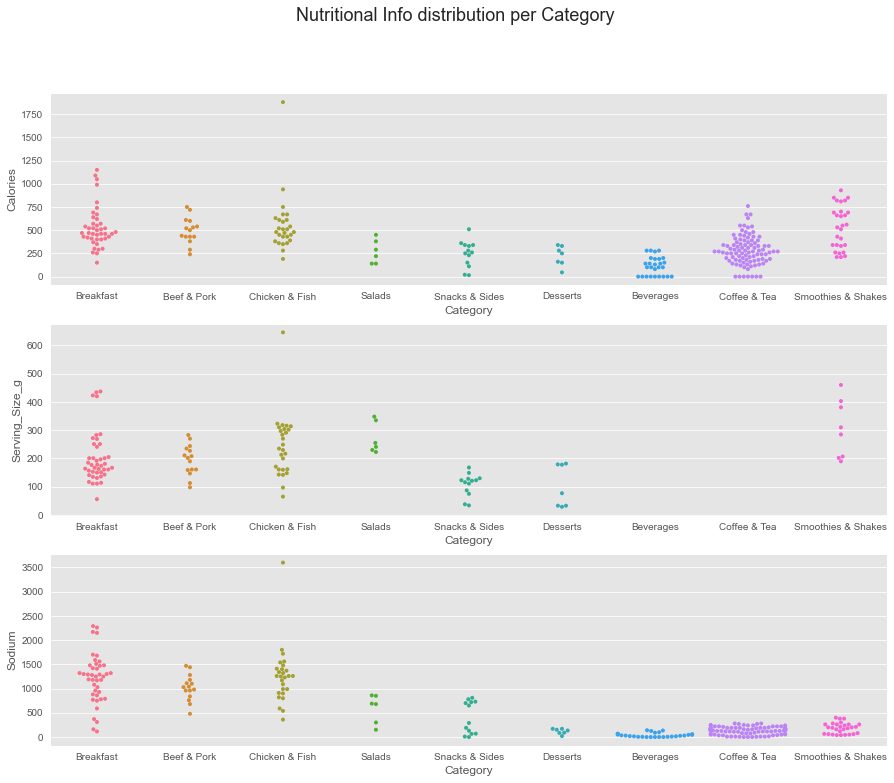

In [98]:
# First we check some of the attributes distribution divided on each of the different food categories. 

fig, axes = plt.subplots( 3, 1, figsize=(15, 12))
fig.suptitle('Nutritional Info distribution per Category', fontsize=18)
ax1 = sns.swarmplot(ax = axes[0],x = 'Category', y = 'Calories', data = df, s = 4, hue = 'Category')
ax2 = sns.swarmplot(ax = axes[1],x = 'Category', y = 'Serving_Size_g', data = df, s = 4, hue = 'Category')
ax3 = sns.swarmplot(ax = axes[2],x = 'Category', y = 'Sodium', data = df, s = 4, hue = 'Category')
ax1.set_xticklabels(labels=ax1.get_xticklabels(), ha='center')
plt.show();

As we can see on the 'Chicken & Fish' Category we have a pretty big outlier.

In [127]:
# We compare how the distribution of other attributes behave with and without the max.
print(f" The Outlier is: {df.loc[df.index[df['Calories'].idxmax()]].at['Item']}" )
display(df.describe()[-3:][['Serving_Size_g','Calories','Total_Fat','Protein','Sodium', 'Carbohydrates']])
display(df.drop(df.index[df['Calories'].idxmax()]).describe()[-3:][['Serving_Size_g','Calories','Total_Fat','Protein','Sodium', 'Carbohydrates']])

 The Outlier is: Big Breakfast with Hotcakes (Large Biscuit)


,Serving_Size_ml,Serving_Size_g,Calories,Total_Fat,Protein,Sodium,Carbohydrates
50%,473.12,182.0,340.0,11.0,12.0,190.0,44.0
75%,620.97,251.0,490.0,22.0,18.5,860.0,60.0
max,946.24,460.0,1150.0,60.0,48.0,2290.0,141.0


,Serving_Size_ml,Serving_Size_g,Calories,Total_Fat,Protein,Sodium,Carbohydrates
50%,473.12,181.5,340.0,11.0,12.0,190.0,44.0
75%,620.97,251.0,480.0,22.0,18.0,857.5,60.0
max,946.24,460.0,1090.0,59.0,48.0,2290.0,141.0


As observed in the tables above, it is evident that this particular element serves as an outlier in several attributes. To obtain a clearer overview of the data, we have opted to exclude it. This decision is based on the understanding that its outlier status is solely attributable to the serving size. Furthermore, the correlation information associated with this element mirrors that of 'Chicken Nuggets 10 pieces.' Hence, removing it facilitates a more accurate analysis.

In [128]:
# We check some basic statistics about some of the columns in our Dataframe.

df  = df.drop(df.index[df['Calories'].idxmax()]) #We drop an outlier to have a better overview of the general data. 
df.describe()[1:][['Serving_Size_ml','Serving_Size_g','Calories','Total_Fat', 'Carbohydrates','Protein']]

,Serving_Size_ml,Serving_Size_g,Calories,Total_Fat,Carbohydrates,Protein
mean,518.903965,198.525862,359.379845,13.585271,46.806202,12.965116
std,163.296145,89.502340,216.400971,12.365954,27.682912,10.407773
min,177.420000,29.000000,0.000000,0.000000,0.000000,0.000000
25%,354.840000,142.750000,210.000000,2.125000,30.000000,4.000000
50%,473.120000,181.500000,340.000000,11.000000,44.000000,12.000000
75%,620.970000,251.000000,480.000000,22.000000,60.000000,18.000000
max,946.240000,460.000000,1090.000000,59.000000,141.000000,48.000000


In [129]:
# With help of SQLite and a simple query we check the average calories on each food category.

query = %sql SELECT Category, AVG(Calories) AS Average_Calories_Category FROM Mc_Data GROUP BY Category

df_query =  pd.DataFrame(query)
df_query

 * sqlite:///SQLiteMagic.db
Done.


,Category,Average_Calories_Category
0,Beef & Pork,494.000000
1,Beverages,113.703704
2,Breakfast,526.666667
3,Chicken & Fish,552.962963
4,Coffee & Tea,283.894737
5,Desserts,222.142857
6,Salads,270.000000
7,Smoothies & Shakes,531.428571
8,Snacks & Sides,245.769231


In [191]:
print(df['Calories'].describe (), '\n')
print(f"The menu element with the highest ammount of Calories is { df.at[df['Calories'].idxmax(),'Item'] } \n " )


count     258.000000
mean      359.379845
std       216.400971
min         0.000000
25%       210.000000
50%       340.000000
75%       480.000000
max      1090.000000
Name: Calories, dtype: float64 

The menu element with the highest ammount of Calories is Big Breakfast with Hotcakes (Regular Biscuit) 
 


### 2.3 Correlation Analisis

In the correlation analysis segment of the McDonald's nutritional data menu project, our primary focus is to unveil the relationships between various nutritional components and the calorie content of menu items. By examining the degree of association between macronutrients (such as carbohydrates, fats, and proteins) and micronutrients with calorie counts, we aim to discern patterns that illuminate how specific dietary elements contribute to the overall caloric composition of McDonald's offerings. 

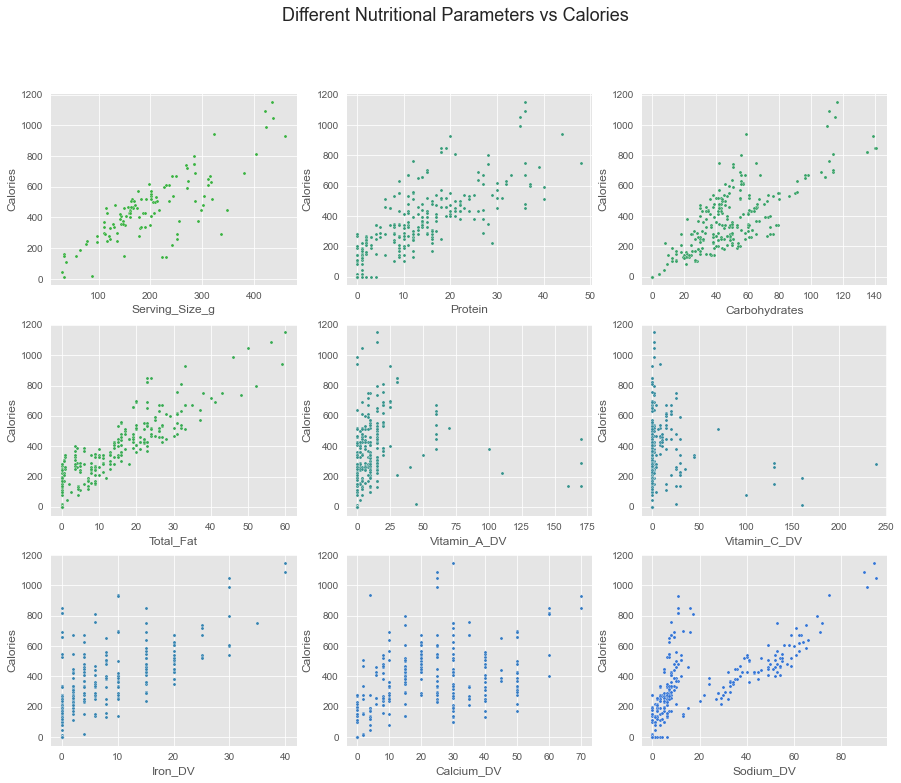

In [103]:
#Now we plot a some of the nutritional elements against the Calories to check for correlations. 

fig, axes = plt.subplots( 3, 3, figsize=(15, 12))
plt.style.use('ggplot')
color1 =  '#3BB143'
color2 = "#3575D5"

fig.suptitle('Different Nutritional Parameters vs Calories', fontsize=18)

sns.scatterplot(ax = axes[0,0], x = 'Serving_Size_g', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[0])
sns.scatterplot(ax = axes[0,1], x = 'Protein', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[3])
sns.scatterplot(ax = axes[0,2], x = 'Carbohydrates', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[2])
sns.scatterplot(ax = axes[1,0], x = 'Total_Fat', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[1])
sns.scatterplot(ax = axes[1,1], x = 'Vitamin_A_DV', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[4])
sns.scatterplot(ax = axes[1,2], x = 'Vitamin_C_DV', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[5])
sns.scatterplot(ax = axes[2,0], x = 'Iron_DV', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[6])
sns.scatterplot(ax = axes[2,1], x = 'Calcium_DV', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[7])
sns.scatterplot(ax = axes[2,2], x = 'Sodium_DV', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[8]);

As expected, there is a noticeable correlation between the serving size and the macronutrient composition, influencing the calorie content of the menu element. Surprisingly, we also observe a correlation between certain micronutrients and the calorie count. This unexpected relationship suggests a deeper connection between the complex interplay of macronutrients and micronutrients, emphasizing that the nutritional profile extends beyond basic energy content. These findings enhance our understanding of nutritional science, reminding us to consider both macro- and micronutrients in evaluating the holistic health impact of our dietary choices. 
We soon explore and quantify this relations in a deeper way by conducting a multiple linear Regression between the nutritional data and the Calories.  

Let's zoom in on the protein macronutrient. We're delving into the details to see how it adds to the bigger picture we've been figuring out.

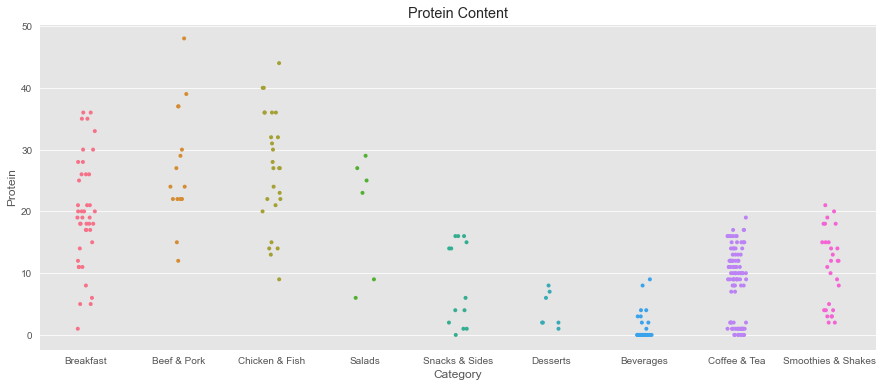

In [104]:
# We check the protein distribution divided on each of the different food categories.

df.describe(include='all')
plt.figure(figsize=(15, 6))
plot = sns.stripplot(x='Category', y='Protein', data=df, s=4, hue = 'Category')
plt.title("Protein Content")
plt.show();

In [105]:
# We check the average protein on each Category.

query = %sql SELECT Category, AVG(Protein) AS "Average_Protein" FROM Mc_Data GROUP BY Category

df_query = pd.DataFrame(query)
df_query

 * sqlite:///SQLiteMagic.db
Done.


,Category,Average_Protein
0,Beef & Pork,27.333333
1,Beverages,1.333333
2,Breakfast,19.857143
3,Chicken & Fish,29.111111
4,Coffee & Tea,8.863158
5,Desserts,4.000000
6,Salads,19.833333
7,Smoothies & Shakes,10.857143
8,Snacks & Sides,8.384615


#### 2.3.1 Simple Linear Regresion 

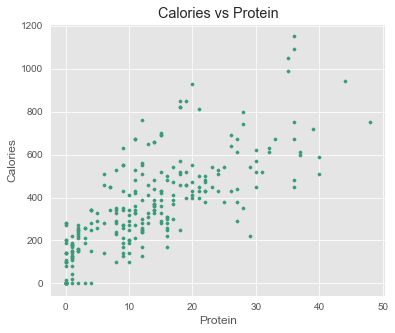

In [106]:
# We take a closer look in the relation between the Calories and the Protein and conduct a Simple Linear Regression as a preamble of the Multiple Linear Regression. 

fig = plt.figure(figsize=(6, 5))
plt.scatter(df['Protein'], df['Calories'], s = 10,color = get_color_gradient(color1, color2, 9)[3])
plt.title('Calories vs Protein')
plt.ylabel('Calories')
plt.xlabel('Protein')
plt.show()

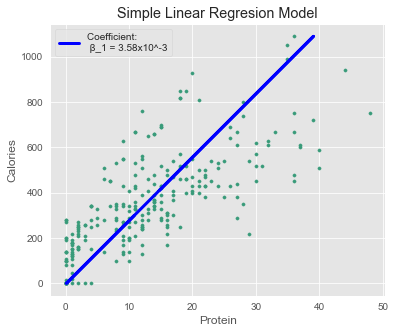

In [148]:
# We do a Simple Linear Regression to quantify the correlation between Protein and Calories.

Protein = np.asarray((df.Protein))
Calories = np.asarray(df.Calories)
Calories = Calories[:,np.newaxis]
regr = linear_model.LinearRegression()
regr.fit(Calories, Protein)
simple_regresion = regr.predict(Calories)
fig = plt.figure(figsize=(6, 5))
plt.plot(simple_regresion,Calories, color="blue", linewidth=3)
plt.scatter(Protein,Calories ,  s=10, color = get_color_gradient(color1, color2, 9)[3])
plt.title("Simple Linear Regresion Model")
plt.ylabel('Calories')
plt.xlabel('Protein')
plt.legend([f"Coefficient: \n β_1 = {100*regr.coef_[0]:.2f}x10^-3"])
plt.show()

#### 2.3.2 Multiple Linear Regresion (MLR) 

We proceed with a MLR using the macronutrients and micronutrients that seem to exhibit the highest correlation levels with the calorie content of the food, that is with 'Protein','Carbohydrates', 'Total_Fat', 'Iron_DV', 'Calcium_DV', 'Sodium_DV'. This approach allows us to quantify the relationship between these nutritional components and the calorie count.

In [177]:
X = df[['Protein','Carbohydrates', 'Total_Fat', 'Iron_DV', 'Calcium_DV', 'Sodium_DV']]
y = df['Calories']

regr = linear_model.LinearRegression()
regr.fit(X, y);

In [178]:
print(regr.coef_)
print(regr.intercept_)

[3.84301693 3.94899776 9.02577665 0.16127489 0.10863819 0.02921981]
-1.978327450608333


In [179]:
r2_score(y, regr.predict(X))

0.9993766734553688

Given the robust correlation between the macronutrients and the calorie content, our multiple linear regression model demonstrates a nearly perfect fit to the data.

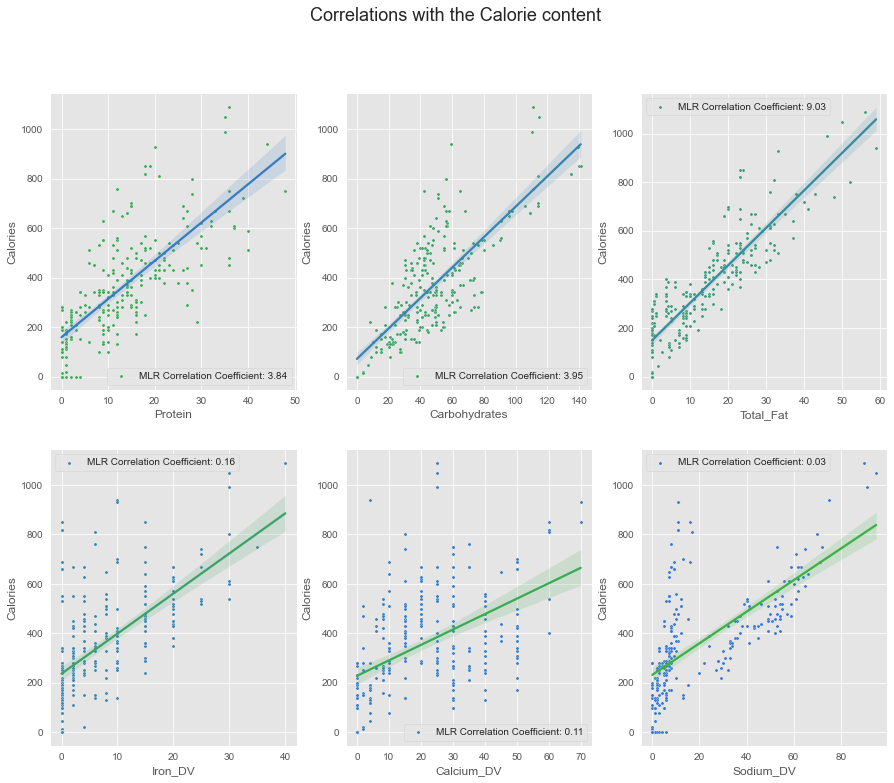

In [189]:
fig, axes = plt.subplots( 2, 3, figsize=(15, 12))
plt.style.use('ggplot')
color1 = '#3BB143'
color2 = "#3575D5"

fig.suptitle('Correlations with the Calorie content', fontsize=18)


sns.scatterplot(ax = axes[0,0], x = 'Protein', y = 'Calories',s=10, data = df, color = get_color_gradient(color1, color2, 9)[1],label = f"MLR Correlation Coefficient: {regr.coef_[0]:.2f}")
sns.regplot(ax = axes[0,0], x = 'Protein', y = 'Calories',scatter=False, data = df, color = get_color_gradient(color1, color2, 9)[7])

sns.scatterplot(ax = axes[0,1], x = 'Carbohydrates', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[2],label = f"MLR Correlation Coefficient: {regr.coef_[1]:.2f}")
sns.regplot(ax = axes[0,1], x = 'Carbohydrates', y = 'Calories',scatter=False, data = df, color = get_color_gradient(color1, color2, 9)[6])

sns.scatterplot(ax = axes[0,2], x = 'Total_Fat', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[3],label = f"MLR Correlation Coefficient: {regr.coef_[2]:.2f}")
sns.regplot(ax = axes[0,2], x = 'Total_Fat', y = 'Calories',scatter=False, data = df, color = get_color_gradient(color1, color2, 9)[5])

sns.scatterplot(ax = axes[1,0], x = 'Iron_DV', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[6],label = f"MLR Correlation Coefficient: {regr.coef_[3]:.2f}")
sns.regplot(ax = axes[1,0], x = 'Iron_DV', y = 'Calories',scatter=False, data = df, color = get_color_gradient(color1, color2, 9)[2])

sns.scatterplot(ax = axes[1,1], x = 'Calcium_DV', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[7],label = f"MLR Correlation Coefficient: {regr.coef_[4]:.2f}")
sns.regplot(ax = axes[1,1], x = 'Calcium_DV', y = 'Calories',scatter=False, data = df, color = get_color_gradient(color1, color2, 9)[1])

sns.scatterplot(ax = axes[1,2], x = 'Sodium_DV', y = 'Calories', data = df, s = 10, color = get_color_gradient(color1, color2, 9)[8],label = f"MLR Correlation Coefficient: {regr.coef_[5]:.2f}")
sns.regplot(ax = axes[1,2], x = 'Sodium_DV', y = 'Calories',scatter=False, data = df, color = get_color_gradient(color1, color2, 9)[0]);

### 2.3.3 Predictive Model 

To conclude the project, we embark on creating a predictive model employing the test-train split methodology. This time, we narrow our focus to micronutrients in the multiple linear regression analysis. The decision to exclusively incorporate micronutrients makes the task more challenging, as their relationship with calorie content is not as straightforward as with macronutrients. By doing so, we aim to delve into the intricacies of the nutritional composition and assess the model's ability to predict calorie content based on these more nuanced factors. This approach enhances the depth of our analysis and offers insights into the nuanced interplay between micronutrients and calorie counts in McDonald's menu items.

In [201]:
X = df[['Vitamin_A_DV','Vitamin_C_DV', 'Iron_DV', 'Sodium_DV', 'Calcium_DV']]
y = df['Calories']

np.random.seed(100)

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size =0.5)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train);
r2_score(y_test, regr.predict(X_test))

0.6948129424110074

The R2 score analysis reveals a compelling insight: up to 70% of the variation in the Calorie content is predictable solely by considering micronutrients. While this percentage is notably lower than the R2 Score attained with the MLR using macronutrients, it unveils a valuable dimension of information within seemingly less correlated variables. This finding underscores the nuanced and intricate relationship between micronutrients and calorie content, offering a substantial contribution to our understanding of the nutritional dynamics in McDonald's menu items.

## 3. Conclusions

In conclusion, our exploratory and correlation analysis of the McDonald's Menu Nutritional Data has shed light on the intricate relationships within the menu offerings. Through meticulous examination of macronutrients and micronutrients, we uncovered robust correlations with calorie content, leading to a highly effective predictive model. While the model's performance was affected at focusing exclusively on micronutrients, the insights gained underscore the complexity of nutritional interplay. This project provides a comprehensive understanding of how specific dietary components contribute to the overall nutritional profile of McDonald's menu items, offering valuable implications for both dietary research and public health considerations.